In [324]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pyplot
import random
from itertools import product



def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)



def propagator(evals,evec,t):
    expL = np.einsum("ik,k,jk->ij",evec,np.exp(-t*evals),evec)
    return expL/np.trace(expL) 



def K(evals,evec,t):
    expL = np.einsum("ik,k,jk->ij",evec,np.exp(-t*evals),evec)
    return expL 


    
def truncate_evec(evals,evec,lambda_thresh = -np.inf):
    Eval = np.zeros_like(evec)
    Eval[np.diag_indices_from(Eval)] = evals
    mask = evals > lambda_thresh
    trunc_evec = np.einsum("ij,j->ij",evec,mask)
    return trunc_evec
    


def partion_by_K(K,n):
    N = K.shape[0]
    Ka = abs(K)
    Ka[np.diag_indices_from(Ka)] = 0
    Ka = np.ravel(Ka)
    sKa_i = np.flip(np.argsort(Ka))
    sKa = np.ravel(Ka)[sKa_i]
    sKa_ij = [np.unravel_index(r_i,K.shape) for r_i in sKa_i]
    part = [(i,) for i in range()]
    while(len(part) > N-n):   
        (ki,kj) = sKa_ij[0]
        if(ki == kj):
            break
        for (i,p) in part:
            if(ki in p) and (kj in p):
                break
            if
    return part
    


def partion_by_evec(evec):
    v = np.arange(0,len(evec))
    sevec = np.sign(evec)
    vs = [()]
    tmp = ()
    repr = []
    for i in range(len(evec)-1):
        if(len(tmp) == 0):
            tmp = tmp + (i,)
            repr = repr + [sevec[i]]
        if(sevec[i] == sevec[i+1]):
            tmp = tmp + (i+1,)
        else:
            vs = vs + [tmp]
            tmp = ()
    return vs[1:], repr[:-1]


def meta_pos(part,X,Y,Z):
    meta_X = np.zeros(len(part))
    meta_Y = np.zeros(len(part))
    meta_Z = np.zeros(len(part))
    z = Z[0]
    for i in range(len(part)):
        p = part[i]
        meta_X[i] = np.take(X,p).mean()
        meta_Y[i] = np.take(Y,p).mean()
        meta_Z[i] = z-1
    return meta_X, meta_Y, meta_Z 


def meta_edges(part,edges):
    meta_edges = []
    for (i,pi) in enumerate(part):
        for (j,pj) in enumerate(part):
            if(i == j):
                continue
            else:
                for edge in product(pi,pj):
                    if edge in edges:
                        meta_edges.append((i,j))
                        break
    return meta_edges

            
                




In [335]:
[0,0,1].any()

AttributeError: 'list' object has no attribute 'any'

In [326]:

G = np.genfromtxt("G.csv",delimiter=",")
sid = np.genfromtxt("sid.csv",delimiter=",")
c = np.genfromtxt("C.csv",delimiter=",")
c_mh = (c**(-0.5))
A = G
A[np.diag_indices_from(A)] = 0
A[A!=0] = 1


C_hi = 0*G
C_hi[np.diag_indices_from(C_hi)] = c_mh
G = np.einsum("it,ts,sj->ij",C_hi,G,C_hi)
d = G.sum(0)
D = np.zeros_like(G)
D[np.diag_indices_from(D)] = d
WA = G
WA[np.diag_indices_from(WA)] = 0 
Lw = D -WA
Eigen = np.linalg.eigh(Lw)
evals = Eigen.eigenvalues
evec = Eigen.eigenvectors
sevec = np.sign(evec)
sevec_labs = np.full(sevec.shape," ")
sevec_labs[sevec == 1] = "blue"
sevec_labs[sevec == 1] = "red"


nrn = nx.from_numpy_array(A)
nx.number_connected_components(nrn)
cyc = list(nx.simple_cycles(nrn))
nx.is_tree(nrn)
pos = hierarchy_pos(nrn,root=0)
#pos = nx.spring_layout(nrn)




In [327]:
np.unravel_index(np.argmax(WA),WA.shape)

(113, 131)

In [330]:
pos3d = [(pos[k][0],pos[k][1],-1) for k in pos.keys()]
X,Y,Z = zip(*pos3d)
mx = np.min(X); Mx = np.max(X); sx = np.std(X)
mz = np.min(Z); Mz = np.max(Z); sz = np.std(Z)
my = np.min(Y); My = np.max(Y); sy = np.std(Y) 

In [331]:
n = 10
trunc_evec = truncate_evec(evals,evec,evals[n] + 1e-6)
part_sevec = sevec[:,n]
part, repr = partion_by_evec(part_sevec)
meta_X,meta_Y,meta_Z = meta_pos(part,X,Y,Z)
meta_E = meta_edges(part,list(nrn.edges))

In [332]:
rho = propagator(evals,evec,1/evals[n])
edge_c = []
for edge in nrn.edges:
    edge_c = edge_c + [rho[edge]]




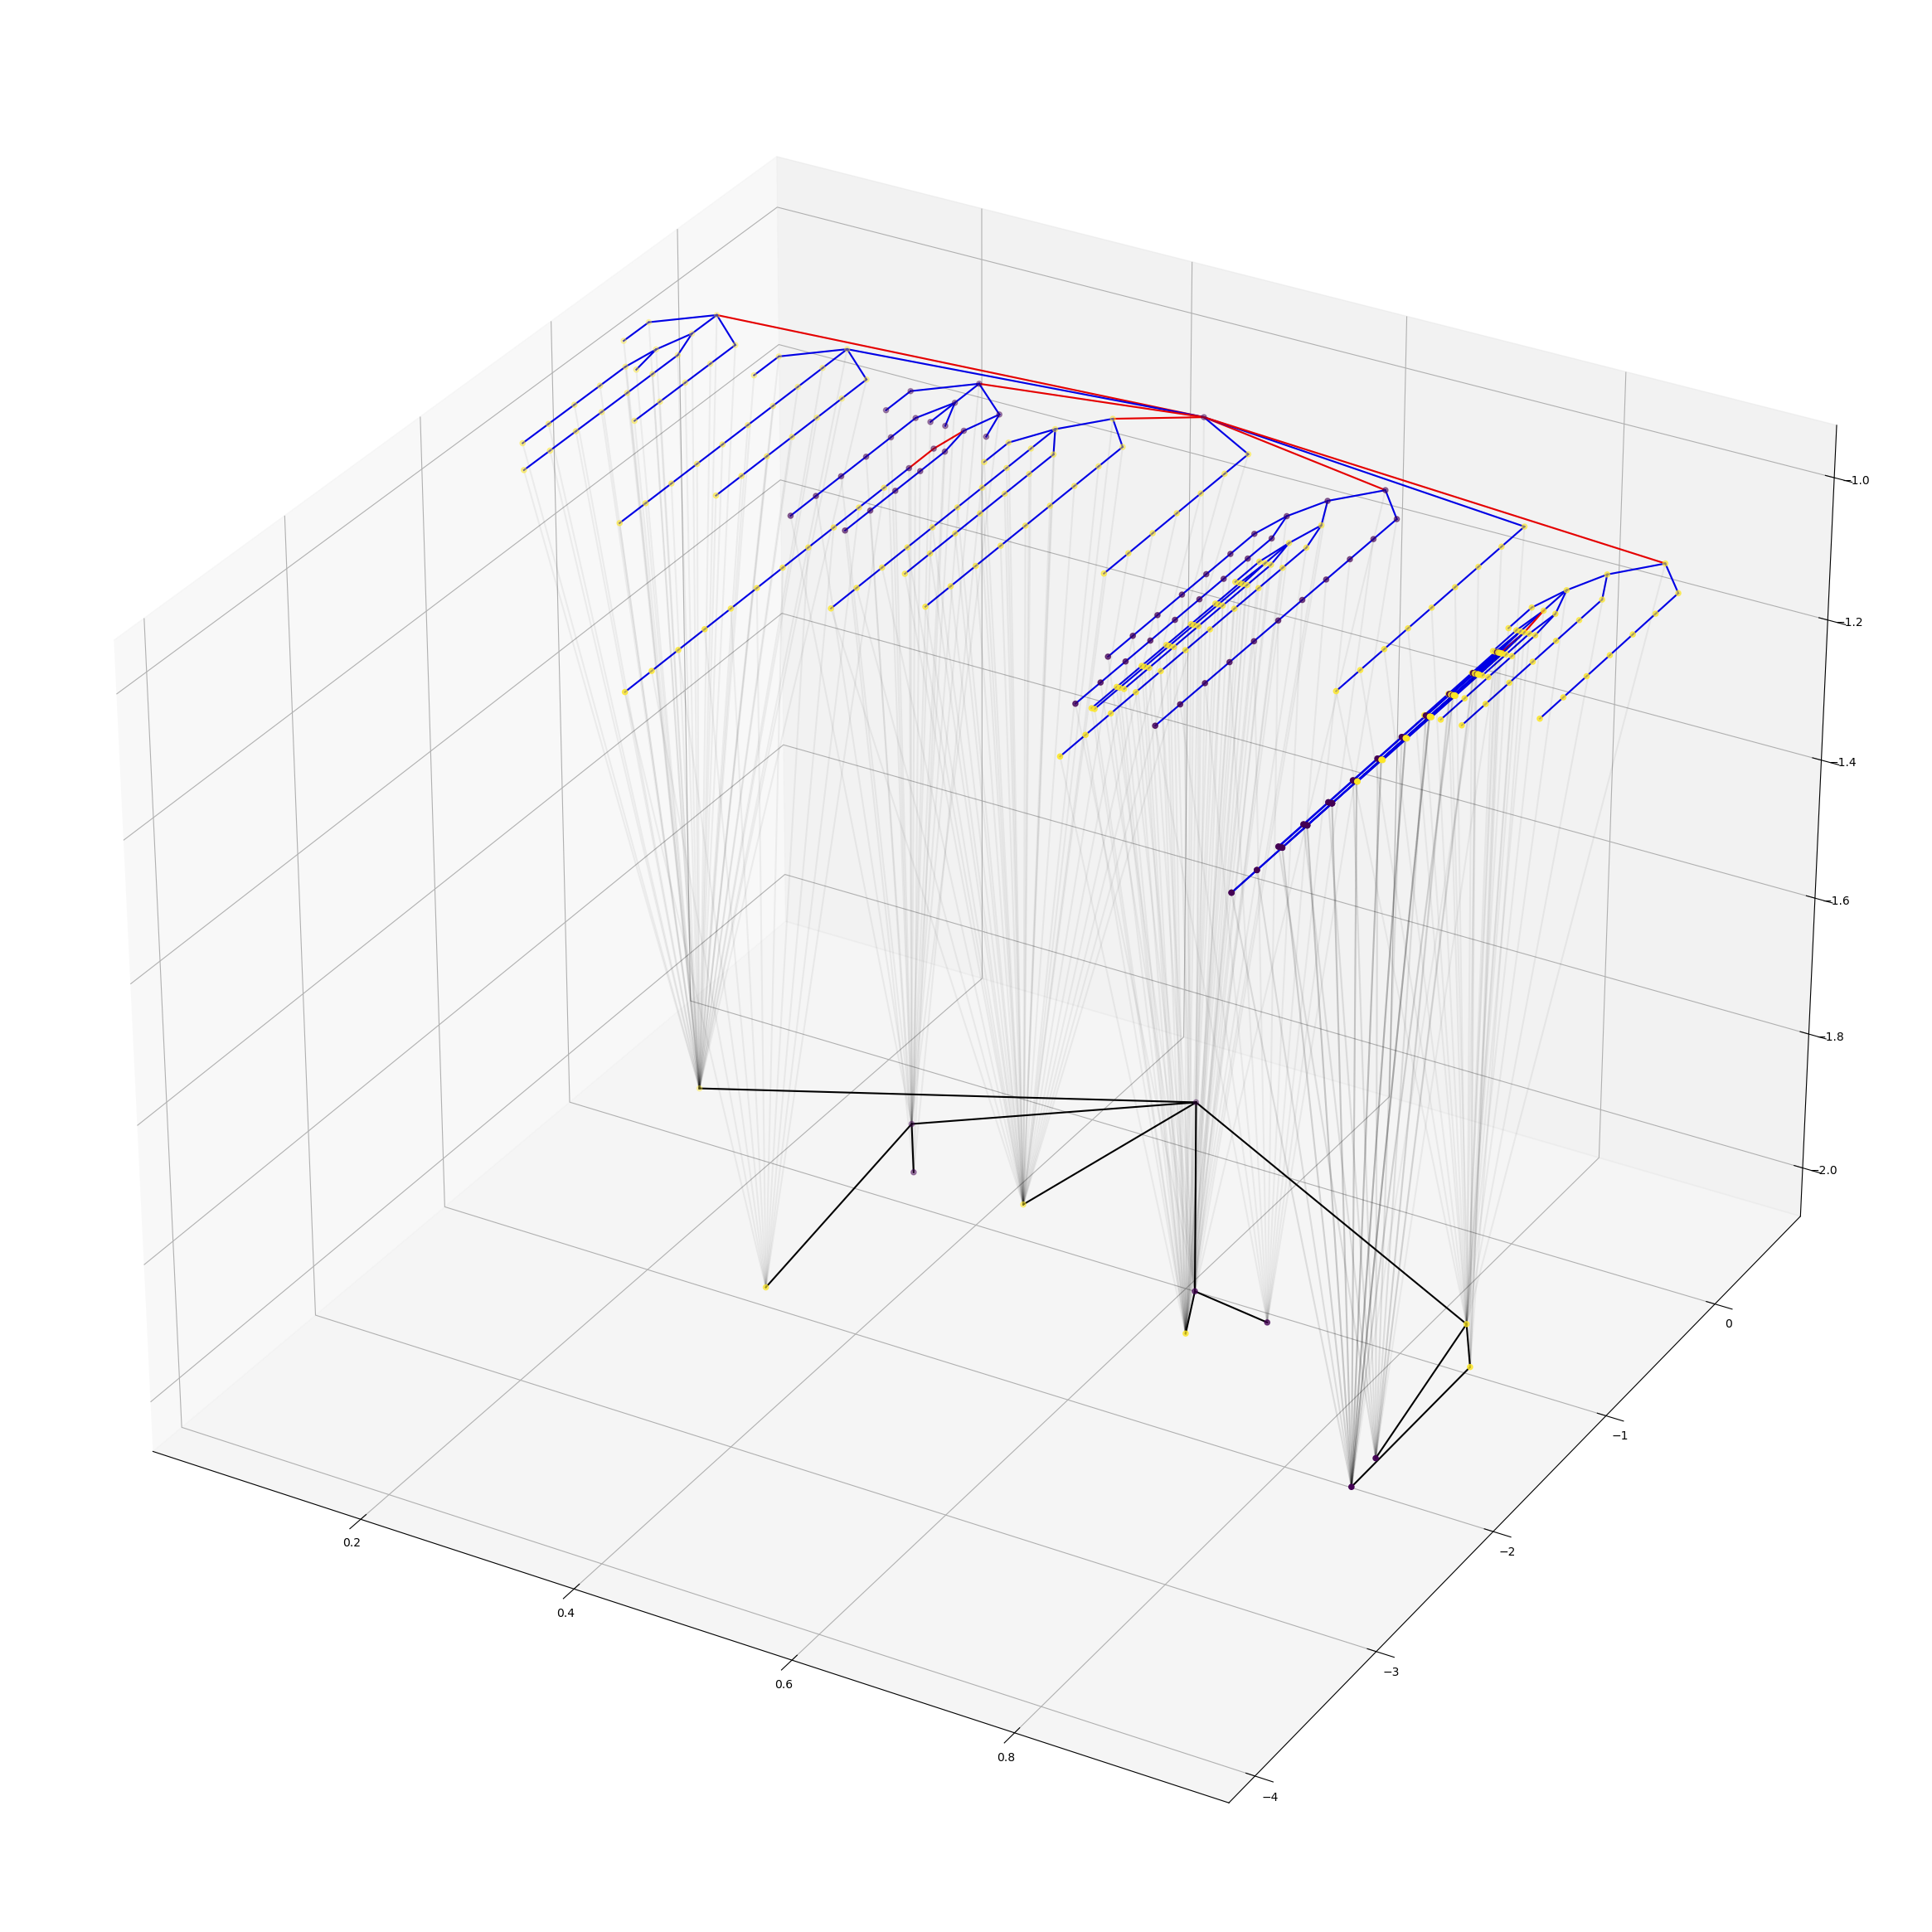

In [336]:

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(projection="3d")
ax.scatter(X,Y,Z,c=part_sevec)
ax.scatter(meta_X,meta_Y,meta_Z,c=np.array(repr ))

ax.set_ylim(bottom=my-sy,top=My+sy)
ax.set_xlim(left=mx,right=Mx)
k = 0
for edge in nrn.edges:
    (i,j) = edge
    ax.plot([X[i],X[j]],[Y[i],Y[j]],zs=[Z[i],Z[j]],color=(1-edge_c[k],0,edge_c[k]))
    ax.plot([X[i],X[j]],[Y[i],Y[j]],zs=[Z[i],Z[j]],color=(0,0,0,0.1))

    k += 1


for edge in meta_E:
    (i,j) = edge
    ax.plot([meta_X[i],meta_X[j]],[meta_Y[i],meta_Y[j]],zs=[meta_Z[i],meta_Z[j]],color="k")

for (i,childs) in enumerate(part):
    for j in childs:
        ax.plot([meta_X[i],X[j]],[meta_Y[i],Y[j]],zs=[meta_Z[i],Z[j]],color="k",alpha=0.05)